In [2]:
import numpy as np
import healpy as hp
from astropy.utils.data import get_pkg_data_filename
import matplotlib.pylab as plt
import matplotlib.patches as patches
# import pyfits
import astropy.io.fits as pyfits
from scipy.stats import binned_statistic
from astropy.io import ascii
import matplotlib.cm as cm
from healpy.newvisufunc import projview, newprojplot
import pylab as pl
import math
from astropy.io import fits
import random
import csv
import sys
# from tqdm import tqdm
import scipy

In [11]:
#import the maps and their masks
two_mass_map=hp.read_map("two_mass_map_without_mask.fits")
alfalfa_map=hp.read_map("alfalfa_map_without_mask.fits")
two_mass_mask = hp.read_map("2M++_115_mask_nside512.fits").astype(np.bool_)
alfalfa_mask=hp.read_map("alfalfa_mask.fits").astype(np.bool_)

# Construct the combined mask

0.0 180.0 -180.0 180.0


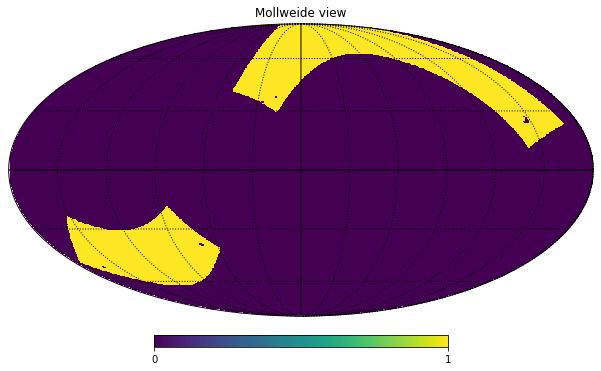

In [17]:
#find the combined mask for both maps

nside=512
npix=hp.nside2npix(nside)
m = np.zeros(hp.nside2npix(nside))#create an empty map to check the mask

#check each pixel in both masks and see if they matches
for i in range(npix):
    if two_mass_mask[i]==alfalfa_mask[i]:
        if two_mass_mask[i]==True:#the boolean function should be "true" in both maps
            m[i]=hp.UNSEEN
combined_mask=hp.mask_bad(m)

#hp.write_map("cross_correlation_mask.fits",combined_mask)#save the mask

#plot the map to check if it fits
m_masked=hp.ma(m)
m_masked.mask=np.logical_not(combined_mask)

hp.mollview(combined_mask)
hp.graticule()

In [18]:
#mask the 2mass map with the combined mask
two_mass_masked=hp.ma(two_mass_map)
two_mass_masked.mask=np.logical_not(combined_mask)

#mask the alfalfa map
alfalfa_masked=hp.ma(alfalfa_map)
alfalfa_masked.mask=np.logical_not(combined_mask)

# Make the contrast map

In [27]:
#make the contrast map accordingly

total_pixel=np.sum(combined_mask)

#calculate the mean number of galaxies per pixel in both maps by total number of galaxies in the masked map/total number of pixels in the map
mean_2_mass=np.sum(two_mass_masked)/total_pixel 
mean_n_g_alfalfa=np.sum(alfalfa_masked)/total_pixel

#construct the contrast

alfalfa_contrast=(alfalfa_masked-mean_n_g_alfalfa)/mean_n_g_alfalfa
two_mass_contrast=(two_mass_masked-mean_2_mass)/mean_2_mass


In [26]:
print(total_pixel)

467275


# correction of the pixelization and beam smearing effects

In [29]:
#calculate the cross power spectrum
cl=hp.anafast(alfalfa_contrast,two_mass_contrast)

#calculate the beam window function (bl) and pixel window function (pl)

pl=hp.pixwin(nside=512,lmax=cl.size-1)
bl=hp.gauss_beam(fwhm=0.0011053752,lmax=cl.size-1)#the value of FWHM was obtained from the alfalfa technical details, which is 3'8 and is converted into radians
wl=np.sqrt(pl**2*bl)#wl is the window function

#after correction in pixel and beam effects
cl_beam=cl/(wl**2)


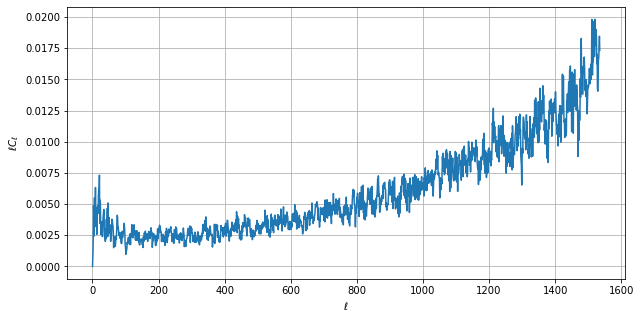

In [32]:
#plot and view the cross power spectrum

ell = np.arange(len(cl_beam))
plt.figure(figsize=(10, 5))
plt.plot(ell, ell  * cl_beam)
#plt.yscale("log")
plt.xlabel("$\ell$")
plt.ylabel("$\ell C_{\ell}$")
plt.grid()

# Compute the cross correlation for different HI mass groups of ALFALFA galaxies

In [39]:
#import the maps of different HI mass groups

alfalfa_map_1=hp.read_map("alfalfa_map_1.fits")
alfalfa_map_2=hp.read_map("alfalfa_map_2.fits")
alfalfa_map_3=hp.read_map("alfalfa_map_3.fits")
alfalfa_map_4=hp.read_map("alfalfa_map_4.fits")
alfalfa_map_5=hp.read_map("alfalfa_map_5.fits")
alfalfa_map_6=hp.read_map("alfalfa_map_6.fits")
alfalfa_map_7=hp.read_map("alfalfa_map_7.fits")
alfalfa_map_8=hp.read_map("alfalfa_map_8.fits")
alfalfa_map_9=hp.read_map("alfalfa_map_9.fits")
alfalfa_map_10=hp.read_map("alfalfa_map_10.fits")
alfalfa_map_11=hp.read_map("alfalfa_map_11.fits")
alfalfa_map_12=hp.read_map("alfalfa_map_12.fits")
alfalfa_map_13=hp.read_map("alfalfa_map_13.fits")

In [40]:
#mask all the maps

for i in range(13):
    globals()['alfalfa_map_masked_%s' % (i+1)]=hp.ma(globals()['alfalfa_map_%s' % (i+1)])
    globals()['alfalfa_map_masked_%s' % (i+1)].mask=np.logical_not(combined_mask)


In [51]:
#compute the contrast map

for i in range (13):
    #calculate the mean number of galaxies per pixel in maps
    mean_n_g=np.sum(globals()['alfalfa_map_masked_%s' % (i+1)])/total_pixel
    #compute the contrast
    globals()['alfalfa_mass_contrast_%s' % (i+1)]=(globals()['alfalfa_map_masked_%s' % (i+1)]-mean_n_g)/mean_n_g


In [52]:
#compute the cross correlation with each mass group map

for i in range(13):
     globals()['cl_mass_%s' % (i+1)]=hp.anafast(two_mass_contrast,globals()['alfalfa_mass_contrast_%s' % (i+1)])

In [53]:
#eliminate the pixelization and beam smearing effects in each group

for i in range(13):
    pl=hp.pixwin(nside=512,lmax=globals()['cl_mass_%s' % (i+1)].size-1)
    bl=hp.gauss_beam(fwhm=0.0011053752,lmax=globals()['cl_mass_%s' % (i+1)].size-1)
    wl=np.sqrt(pl**2*bl)
    globals()['cl_%s' % (i+1)]=globals()['cl_mass_%s' % (i+1)]/(wl**2)

Text(0.52, 0.32, '$M_{HI}>10^{10.4}$')

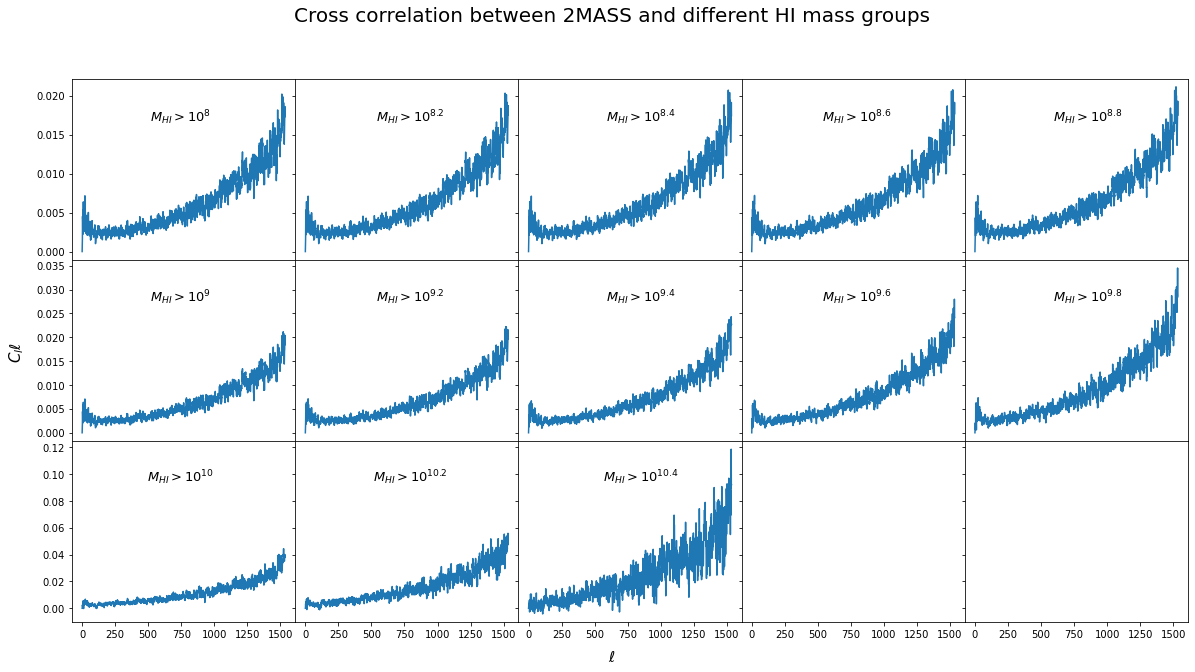

In [57]:
#plot all cross spectrum

for i in range(13):
    globals()['ell_%s' % (i+1)]=np.arange(len( globals()['cl_%s' % (i+1)]))

fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(3, 5, hspace=0, wspace=0)
(ax1, ax2,ax3,ax4,ax5), (ax6, ax7,ax8,ax9,ax10),(ax11,ax12,ax13,ax14,ax15) = gs.subplots(sharex='col', sharey='row')
fig.suptitle('Cross correlation between 2MASS and different HI mass groups',fontsize=20)

ax1.plot(ell_1, ell_1*cl_1)
#ax1.set_yscale('log')
ax2.plot(ell_2, ell_2*cl_2)
ax3.plot(ell_3, ell_3*cl_3)
ax4.plot(ell_4, ell_4*cl_4)
ax5.plot(ell_5, ell_5*cl_5)
ax6.plot(ell_6, ell_6*cl_6)
#ax6.set_yscale('log')
ax7.plot(ell_7, ell_7*cl_7)
ax8.plot(ell_8, ell_8*cl_8)
ax9.plot(ell_9, ell_9*cl_9)
ax10.plot(ell_10, ell_10*cl_10)
ax11.plot(ell_11, ell_11*cl_11)
#ax11.set_yscale('log')
ax12.plot(ell_12, ell_12*cl_12)
ax13.plot(ell_13, ell_13*cl_13)
    
fig.text(0.5, 0.07, '$\ell$', ha='center',fontsize=15)
fig.text(0.08, 0.5, '$C_l \ell$', va='center', rotation='vertical',fontsize=15)
#name each subplot
fig.text(0.2, 0.82, '$M_{HI}>10^8$', ha='center',fontsize=13)
fig.text(0.36, 0.82, '$M_{HI}>10^{8.2}$', ha='center',fontsize=13)
fig.text(0.52, 0.82, '$M_{HI}>10^{8.4}$', ha='center',fontsize=13)
fig.text(0.67, 0.82, '$M_{HI}>10^{8.6}$', ha='center',fontsize=13)
fig.text(0.83, 0.82, '$M_{HI}>10^{8.8}$', ha='center',fontsize=13)
fig.text(0.2, 0.57, '$M_{HI}>10^9$', ha='center',fontsize=13)
fig.text(0.36, 0.57, '$M_{HI}>10^{9.2}$', ha='center',fontsize=13)
fig.text(0.52, 0.57, '$M_{HI}>10^{9.4}$', ha='center',fontsize=13)
fig.text(0.67, 0.57, '$M_{HI}>10^{9.6}$', ha='center',fontsize=13)
fig.text(0.83, 0.57, '$M_{HI}>10^{9.8}$', ha='center',fontsize=13)
fig.text(0.2, 0.32, '$M_{HI}>10^{10}$', ha='center',fontsize=13)
fig.text(0.36, 0.32, '$M_{HI}>10^{10.2}$', ha='center',fontsize=13)
fig.text(0.52, 0.32, '$M_{HI}>10^{10.4}$', ha='center',fontsize=13)

# Calculation of covariance

In [33]:
#calculate the covariance matrix of cross correlation
f_sky_cross=total_pixel/hp.nside2npix(512)
delta_l=20
def cross_cov(l_1,l_2):
    covariance=(np.kron(l_1,l_2)/(f_sky_cross*(2*l_1+1)*delta_l))*(cl_2mass[l_1-1]*cl_alfalfa[l_2-1]+cl_cross[l_1-1]*cl_cross[l_2-1])
    return covariance

l_1=1
l_2=21
covariance=np.array([])
cl_cross=cl_beam
cl_alfalfa=hp.anafast(alfalfa_contrast)
cl_2mass=hp.anafast(two_mass_contrast)
for i in range(50):
    covariance=np.append(covariance,cross_cov(l_1,l_2))
    l_1=l_1+i
    l_2=l_2+i